# Analysis of the generated snippets

In this notebook we will analyze the generated snippets to understand the quality of the generated code.

If you are interested in how the snippets were generated in the first place you can check the ```generation/Code_generation_LLM.ipynb``` notebook.

The evaluatin was separated in two parts:
- **Qualitative evaluation**: Via the ```manual_evaluation_script.py``` file, I manually evaluated the quality of the generated snippets. The evaluation was based on the following criteria:
    - **Overall Satisfaction**: If I were to be suggested this code while working on a project, how satisfied would I be with it?
    - **Similarity**: How similar is the generated code to the original code?
    - **Completeness**: With respect to the original code, how complete is the generated code? Does it include all the necessary parts?
    - **Errors**: How many errors are present in the code? (The higher the score, the fewer the errors therefor the better).
- **Quantitative evaluation**: 
    - Exact Match
    - ChrF score
    - BLEU score
    - METEOR score
    - Levenshtein Distance
    - Precision-Recall-F1 score for the tokenized data (given the same tokenizer)
    - Neural Sentence Embeddings similarities for finetuned models on code

The main goal is to find a quantitative metric that can somewhat correlates well with the qualitative evaluation.

## Env setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util

## Qualitatively Scores Analysis

Here you can find an analysis of the scores obtained by the manual evaluation of the generated code.
The scores are in range [1,5] where 1 is the worst and 5 is the best. The code generated was evaluated by me based on the following criteria:
- **Overall Satisfaction**: If I were to be suggested this code while working on a project, how satisfied would I be with it?
- **Similarity**: How similar is the generated code to the original code?
- **Completeness**: With respect to the original code, how complete is the generated code? Does it include all the necessary parts?
- **Errors**: How many errors are present in the code? (The higher the score, the fewer the errors therefor the better).

Some more insight can be said about some metrics:
- **Similarity**: It was quite difficult to rate this metric. As a rule of thumb, if the generated code was accomplishing everything the original code was accomplishing I would rate it high regardless of other parts of the code. However, if the extra-parts were to introduce deviation or errors I would give a lower score.
- **Errors**: Scores 1-2 are for code that actively introduces code errors. Scores 3-4 are for code that has some minor errors but is mostly correct. Score 5 is for code that has no errors.


In [60]:
# Load data from JSON file
with open("manual_scores.json", "r") as f:
    data = json.load(f)

# Extract metrics
satisfaction = [entry["satisfaction"] for entry in data]
similarity = [entry["similarity"] for entry in data]
completeness = [entry["completeness"] for entry in data]
errors = [entry["errors"] for entry in data]


We will now plot the distribution of the scores for each of the metrics, as well as the average score for each of the metrics.

Furthermore, I wanted to print the absolute length difference between the generated samples and the true one. As we will discover later, during manual evaluation I got the impression that the generated code was often longer than the original one. I wanted to check if this was true.

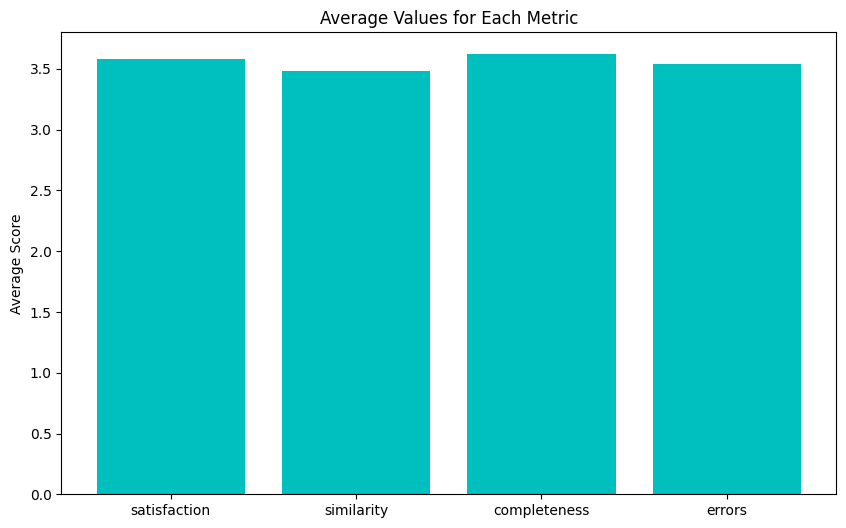

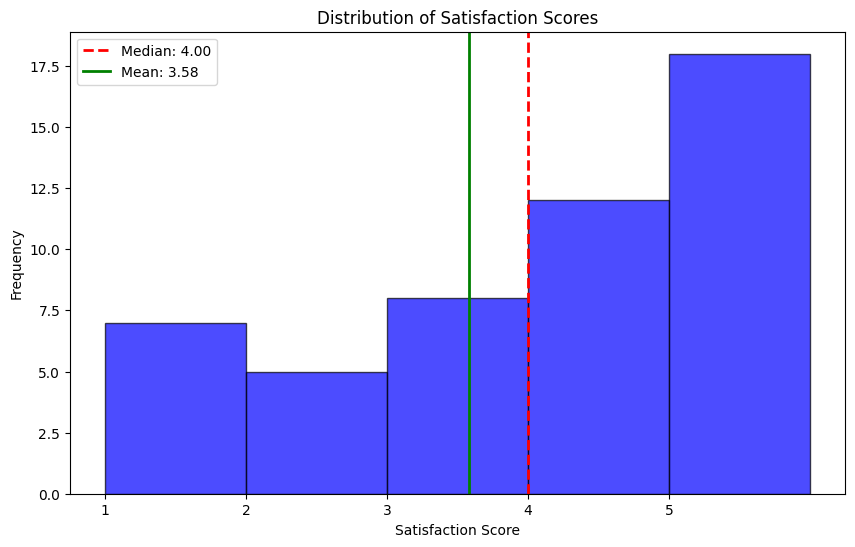

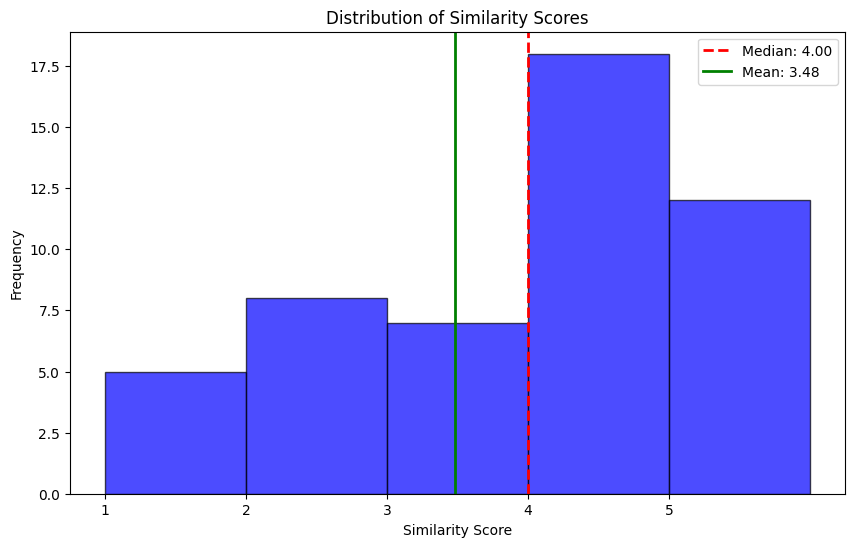

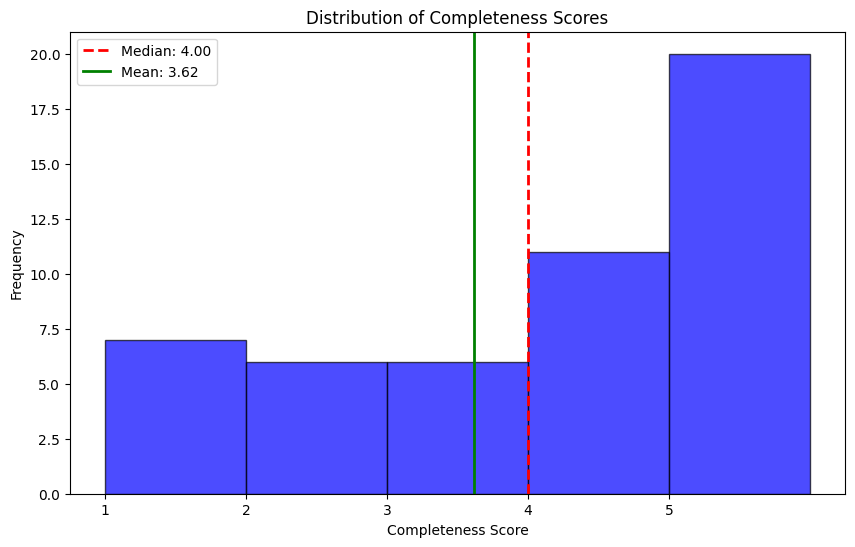

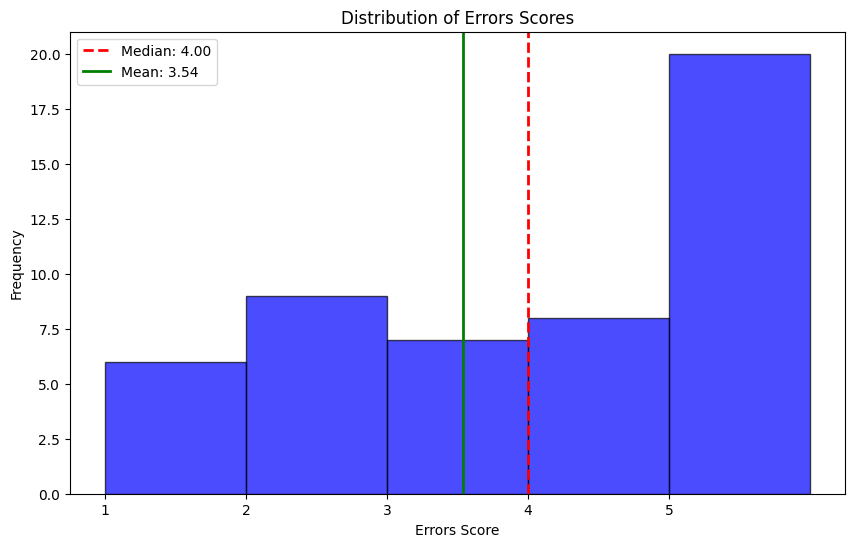

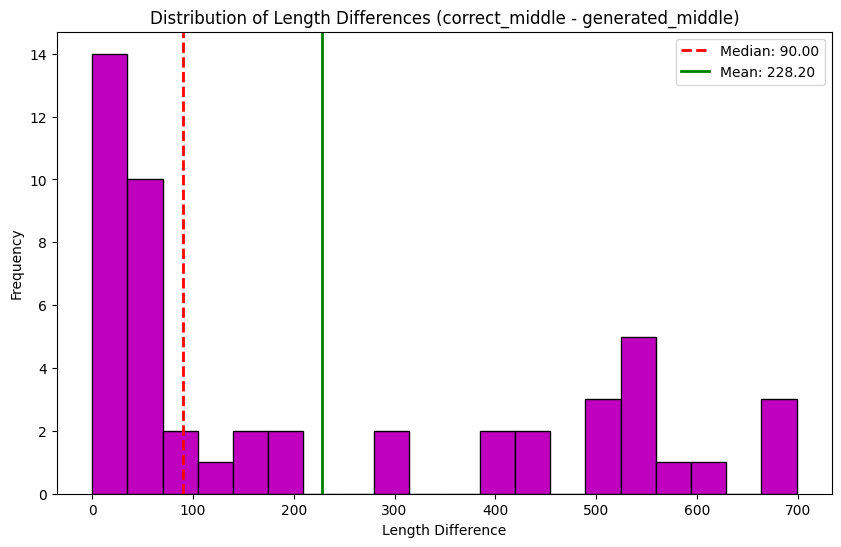

In [83]:
average_scores = {
    "satisfaction": np.mean(satisfaction),
    "similarity": np.mean(similarity),
    "completeness": np.mean(completeness),
    "errors": np.mean(errors)
}

# Plot histogram of average values
plt.figure(figsize=(10, 6))
plt.bar(average_scores.keys(), average_scores.values(), color='c')
plt.title('Average Values for Each Metric')
plt.ylabel('Average Score')
plt.show()

# Histogram for each metric's distribution with median and mean lines
metrics = {"satisfaction": satisfaction, "similarity": similarity, "completeness": completeness, "errors": errors}

for metric, values in metrics.items():
    # Calculate median and mean
    median_value = np.median(values)
    mean_value = np.mean(values)
    
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=range(1, 7), alpha=0.7, color='b', edgecolor='black')
    
    # Add median and mean lines
    plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}', linewidth=2)
    plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}', linewidth=2)
    
    plt.title(f'Distribution of {metric.capitalize()} Scores')
    plt.xlabel(f'{metric.capitalize()} Score')
    plt.ylabel('Frequency')
    plt.xticks(range(1, 6))
    plt.legend()  # Add a legend for median and mean
    plt.show()

# Length difference between correct and generated middle
length_differences = [abs(len(entry["correct_middle"]) - len(entry["generated_middle"])) for entry in data]

plt.figure(figsize=(10, 6))
plt.hist(length_differences, bins=20, color='m', edgecolor='black')

# Add median and mean lines for length differences
median_diff = np.median(length_differences)
mean_diff = np.mean(length_differences)
plt.axvline(median_diff, color='red', linestyle='--', label=f'Median: {median_diff:.2f}', linewidth=2)
plt.axvline(mean_diff, color='green', linestyle='-', label=f'Mean: {mean_diff:.2f}', linewidth=2)

plt.title('Distribution of Length Differences (correct_middle - generated_middle)')
plt.xlabel('Length Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()


It is possible to see from this graph that qualitatevely speaking the model performed quite good.
All of the metrics present a high peak on either 4 or 5 stars out of 5, which is a good sign. The overall satisfaction is the most important metric and it is the one that has the highest peak on 5 stars.

Overall, all the metrics averaged around 3.5 stars. As suspected, the model tends to output more text than neeed consistently.
It is clear in the lenght difference histogram in which there's a long left-tail with negative values. It was a feeling I had while evaluating the code and it is confirmed by the data.

## Quantitative Scores Analysis

1. Exact Match
2. ChrF score
3. BLEU score
4. METEOR score
5. Levenshtein Distance
6. Precision-Recall-F1 score for the tokenized data (given the model tokenizer)
7. Neural Sentence Embeddings

Preparing the data...

In [62]:
out_data = json.load(open("model_outputs.json", "r"))
gold_answers = [entry["correct_middle"] for entry in out_data]
generated_answers = [entry["generated"] for entry in out_data]

### Exact Match

Let's start easy first with a rough but easy to understand metric.
Exact match is defined as:
$$EM = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_i = \hat{y}_i)$$
Where $N$ is the number of samples, $y_i$ is the true code and $\hat{y}_i$ is the generated code.

In [6]:
count = 0
for i in range(len(gold_answers)):
    if gold_answers[i] == generated_answers[i]:
        count += 1
print(f"Percentage of generated answers that are correct: {count / len(gold_answers) * 100:.2f}% ({count} out of {len(gold_answers)})")

Percentage of generated answers that are correct: 4.00% (2 out of 50)


Clearly the exact match metric does not reflect my own findings and it is not a good metric for this task.
I did not expect it to be high either, but it serves as a good baseline.

### ChrF

Character-level F-score is a metric that is used to compare two strings. It uses character-based n-grams to compute the F-score and score how similar are two strings.

In [22]:
chrf_preds = [x for x in generated_answers]
chrf_refs = [[x] for x in gold_answers]
chrf = evaluate.load("chrf")
results = chrf.compute(predictions=chrf_preds, references=chrf_refs)
print(f"CHRF score: {results['score']:.4f}")

CHRF score: 37.5755


ChrF ranges from 0 to 100 (or 0 to 1).

With the ChrF metric we can see that things start to change. The score is still quite bad (<40), but at least is it in a somewhat acceptable range. Still, the ChrF metric reflects the fact that most of the generated code is not the same as the original one. 
This is in line with my own expectation, as the model tends to generate more code than needed.

### BLEU

Given we tested ChrF it would be a shame to skip on BLEU.
BLEU is the most common metric used in Machine Translation tasks for quite a while now. It is also based on n-grams, but it is token-based rather than character-based like ChrF.

My expectations for this metric are quite low, if the model performed poorly on ChrF it will perform poorly on BLEU as well.

In [86]:
# Bleu uses the same format as CHRF so we can reuse the same data
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(predictions=chrf_preds, references=chrf_refs)
print(f"BLEU score: {bleu_results["bleu"]:.4f}")

BLEU score: 0.1405


BLEU can range from 0 to 1 (or 0 to 100 when scaled).

The BLEU metrics performs quite bad.
Indeed, BLEU is very similar to ChrF but, as previously mentioned, it is based on token n-grams rather than characters. As such, there's no surprise that the BLEU metric is even lower than the ChrF metric.
Although it is notably difficult to get high scores in BLEU, this is far from acceptable. And once again does not correlate with my own findings.

I suspect the disalignment in length between the generated code and the true code is the main reason for this.

### METEOR

BLEU and ChrF are quite similar metrics and over the years have been criticized for not being very good at capturing the quality of the generated text.
METEOR is another metric that is used in Machine Translation tasks and it is considered to be better than BLEU and ChrF.

Ideally, METEOR should grasp also the semantic similarities between strings. However, given we are talking about code generation and not human languages, it is dubious how well it will correlate in this case.

In [87]:
meteor = evaluate.load("meteor")
meteor_results = meteor.compute(predictions=generated_answers, references=gold_answers)
print(f"METEOR score: {meteor_results["meteor"]:.4f}")

[nltk_data] Downloading package wordnet to /home/gp-1108/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gp-1108/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/gp-1108/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR score: 0.4153


METEOR can range from 0 to 1 (or 0 to 100 when scaled).

The METEOR metric starts to get to little bit better. It is still quite low ( the reference value of 3.5/5 stars is 0.7 relative score) but it is in a somewhat acceptable range. This is probably also due to the fact that METEOR is a metric that poses more importance on the recall factor, therefore longer sentences are not penalized as much as in BLEU or ChrF.

### Levenshtein Distance

Moving away from standard Machine Translation metrics, I wanted to explore the Levenshtein Distance.

This decision was made because the length difference between the generated code and the true code was quite high and I suspected that this was the main reason for the low scores in the previous metrics.

The Levenshtein Distance is a metric that measures the minimum number of single-character edits required to change one string into another.

In [47]:
def levenshteinDistanceDP(token1, token2):
    """
    Calculate the Levenshtein distance between two tokens using dynamic programming.
    The Levenshtein distance is a measure of the similarity between two strings, 
    which we will refer to as the source string (token1) and the target string (token2). 
    The distance is the number of deletions, insertions, or substitutions required to 
    transform the source into the target.
    Args:
        token1 (str): The first token (source string).
        token2 (str): The second token (target string).
    Returns:
        int: The Levenshtein distance between the two tokens.
    """
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

lev_dists = []
for i in range(len(gold_answers)):
    lev_dists.append(levenshteinDistanceDP(gold_answers[i], generated_answers[i]))

By itself the Levenshtein Distance is a very rough metric, which deals little to no information about the quality of the generated code.
This is due to the fact that it is heavily based on the length of the strings and would not correlate well with our answers which have been proved to be longer than the original code.

Let us see the distribution of the Levenshtein Distance compared to the length difference.

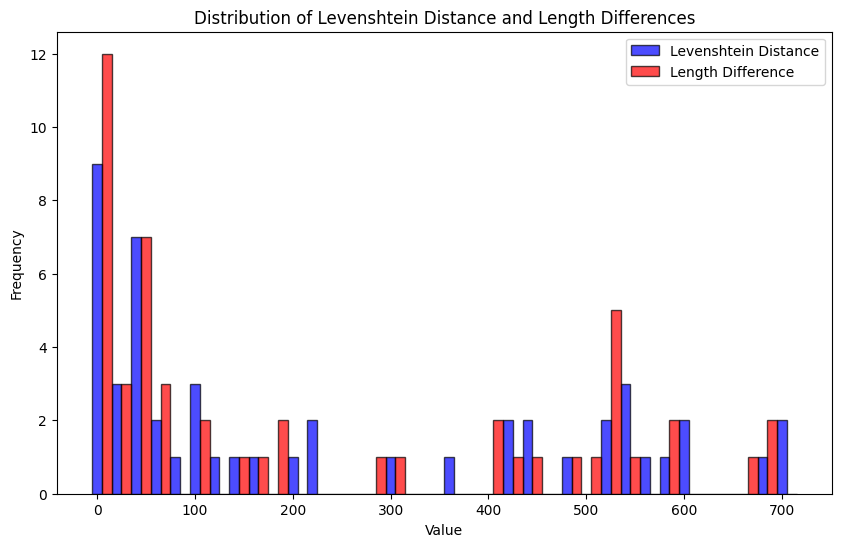

In [57]:
# Setting up for the histogram
bin_size = 20
length_differences = [abs(len(generated_answers[i]) - len(gold_answers[i])) for i in range(len(gold_answers))]
max_val = int(max(max(lev_dists), max(length_differences)))
bins = np.arange(0, max_val+bin_size, bin_size)

# Calculating histogram values for both distributions
lev_hist, _ = np.histogram(lev_dists, bins=bins)
length_hist, _ = np.histogram(length_differences, bins=bins)

# Width of each bar
bar_width = bin_size / 2

# Plotting in the same figure for comparison
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], lev_hist, width=bar_width, alpha=0.7, color='b', edgecolor='black', label='Levenshtein Distance')
plt.bar(bins[:-1] + bar_width, length_hist, width=bar_width, alpha=0.7, color='r', edgecolor='black', label='Length Difference')
plt.title('Distribution of Levenshtein Distance and Length Differences')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


As foreshadowed, the Levenshtein Distance is heavily correlated with the length difference. This is due to the fact that the Levenshtein Distance is based on the number of operations needed to transform one string into another. As such, the longer the strings, the more operations are needed and the higher the Levenshtein Distance.
Let's try to plot now the absolute difference between the Levenshtein Distance and the length difference.

Ideally, if the all the generated answers were to contain the true ones, we would see the difference between the two metrics be zero. The more samples have low difference, the better the model *probably* is.

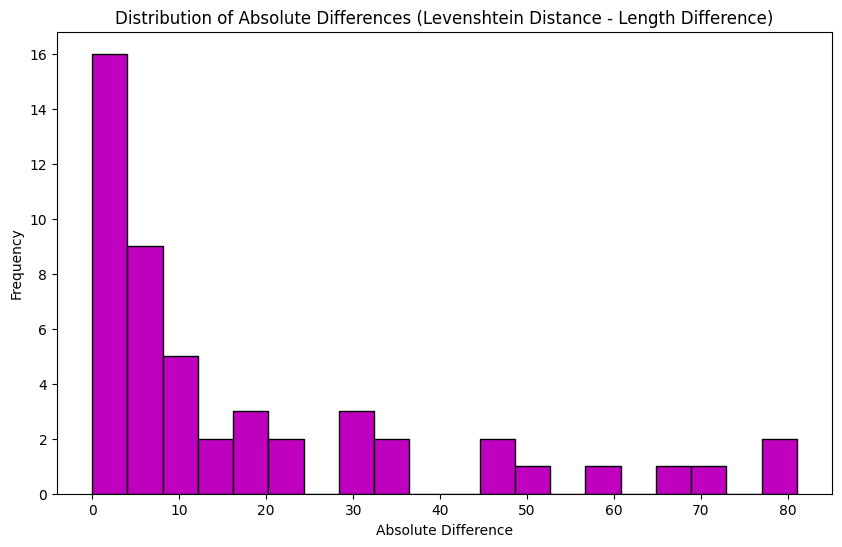

In [63]:
# Additional analysis: Length difference between correct and generated middle
lev_length_diff = [abs(lev_dists[i] - length_differences[i]) for i in range(len(lev_dists))]
plt.figure(figsize=(10, 6))
plt.hist(lev_length_diff, bins=20, color='m', edgecolor='black')
plt.title('Distribution of Absolute Differences (Levenshtein Distance - Length Difference)')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.show()

The plot shows us two things:
* The Levenshtein difference is obviously correlated with the length difference.
* Many of the generated code snippets (once adjusted for the length difference) actually have a low score (meaning they are quite similar to the original code on char-level).

This is not by any means a good metrics, but further proves my insights that the model tends to generate more code than needed, but the code it generates is quite similar to the original code.

From this analysis I would say I have found strong evidence (not proof though) that the the model generates good answers similar to the true code, but it also generates more code than needed.

### Precision-Recall-F1 score for the tokenized data

This idea stems from the ChrF, BLEU, METEOR approaches.
I wanted to replicate those metrics but somehow capture the fact that we are dealing with code and not human languages.

Therefore, I thought that using the model's tokenizer to tokenize the code and then compute the Precision, Recall and F1 score would be a good idea, as it would rupture the n-gram approach and focus on the tokenized data instead.

In [65]:
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
tokenized_gold = [tokenizer.tokenize(x) for x in gold_answers]
tokenized_gen = [tokenizer.tokenize(x) for x in generated_answers]

In [67]:
def get_precision_recall_f1(tokenized_gen: list[str], tokenized_gold: list[str]):
    """
    Calculate the precision, recall, and F1 score of the generated tokens compared to the gold tokens.
    Args:
        tokenized_gen (List[List[str]]): A list of lists of generated tokens.
        tokenized_gold (List[List[str]]): A list of lists of gold tokens.
    Returns:
        Tuple[float, float, float]: The precision, recall, and F1 score values.
    """
    total_precision = 0
    total_recall = 0

    for i in range(len(tokenized_gen)):
        gen_set = set(tokenized_gen[i])
        gold_set = set(tokenized_gold[i])
        intersection = gen_set.intersection(gold_set)
        
        total_precision += len(intersection) / len(gen_set) if len(gen_set) > 0 else 0
        total_recall += len(intersection) / len(gold_set) if len(gold_set) > 0 else 0

    precision = total_precision / len(tokenized_gen)
    recall = total_recall / len(tokenized_gold)

    # Calculating F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    return precision, recall, f1_score

# Example usage
precision, recall, f1_score = get_precision_recall_f1(tokenized_gen, tokenized_gold)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.5752
Recall: 0.6112
F1 Score: 0.5927


Finally, out of all the metrics used so far, this is the one that mostly correlates with my own findings.
I think that this is due to the fact that the tokenized data allows for a more fair comparison between the generated code and the original code.

This is great news as it means that we have found a metric that weakly correlates with the manual evaluation and it is very fast to compute.

### Neural Sentence Embeddings

Given I got a good correlation with the tokenized data, I wanted to try a more advanced approach that were code specific.

Cosine similarity between two vectors is defined as follows:
$$\text{cosine\_similarity} = \frac{A \cdot B}{||A|| \cdot ||B||}$$

Where $A$ and $B$ are the vectors we want to compare. The closer the cosine similarity is to 1, the more similar the two vectors are.

I used a pre-trained model for dense vector representations of code, which was trained on the CodeSearchNet dataset.
You can find the model [here](https://huggingface.co/flax-sentence-embeddings/st-codesearch-distilroberta-base). It is based on the DistilRoBERTa model and was fine-tuned on code specifically.

In [73]:
model = SentenceTransformer("flax-sentence-embeddings/st-codesearch-distilroberta-base")
gen_enc, gold_enc = model.encode(generated_answers), model.encode(gold_answers)
cosine_scores = util.pairwise_cos_sim(gen_enc, gold_enc)

/home/gp-1108/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


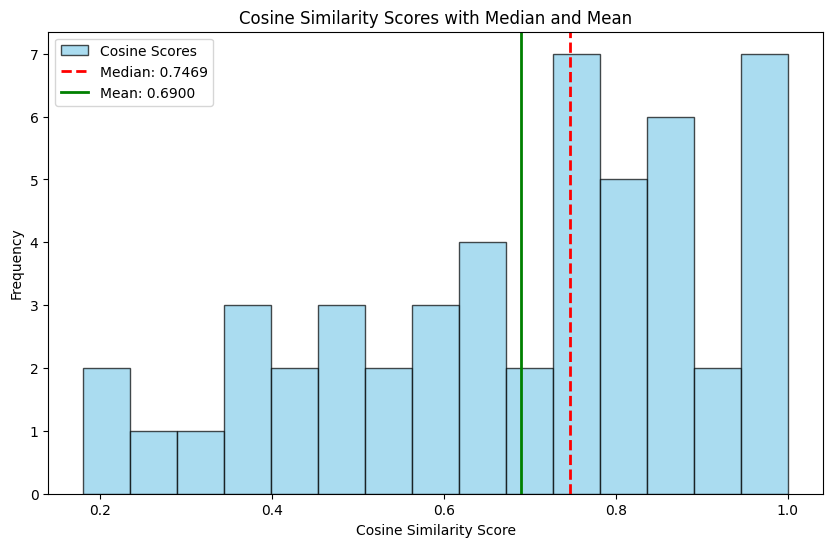

In [81]:
cosine_scores = np.array(cosine_scores)
median_value = np.median(cosine_scores)
mean_value = np.mean(cosine_scores)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram of cosine scores
plt.hist(cosine_scores, bins=15, color='skyblue', edgecolor='black', alpha=0.7, label='Cosine Scores')

# Plot the median as a vertical line
plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.4f}', linewidth=2)

# Plot the mean as a vertical line
plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.4f}', linewidth=2)

plt.title('Cosine Similarity Scores with Median and Mean')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

I have reserved for last the metric that I thought since the beginning would reflect more accurately the quality of the generated code.
It is clear to see that the model is generating code similar to the true one. Not only that but the average and median similarity closely resemble the scores I gave to the code:
- Mean: ~0.7 (3.5/5)
- Median: ~0.75 (3.75/5)
My overall satisfaction mean was 3.5/5, therefore very close.

I think that this finding makes sense: The model generates more code than needed, but the code it generates is quite similar to the original code, so it makes sense that a high-level semantic similarity metric would reflect this.

Runtime was quite fast aswell (although the slowest of all).

## Conclusions

As with any NLP task, evaluation is always as tricky as important.
In this notebook I have tried to evaluate the generated code snippets using both qualitative and quantitative metrics, trying to find a metric that correlates well with the manual evaluation.

We found out that n-grams were not a good approach to evaluation, probably because the generated snippets contain more code than needed. Moving to code-specific metrics, we found that the tokenized data Precision-Recall-F1 score and the Neural Sentence Embeddings similarity were the best metrics to evaluate the generated code.

Below a summary of all results, scaled from 0 to 1.

Qualitative:

| Metric | Average Score | Median Score |
|--------|---------------|--------------|
| Overall Satisfaction | 0.77 | 0.8 |
| Similarity | 0.7 | 0.8 |
| Completeness | 0.72 | 0.8 |
| Errors | 0.71 | 0.6 |


Quantitative:

| Metric | Score |
|--------|-------|
| Exact Match | 0.04 |
| ChrF | 0.37 |
| BLEU | 0.14 |
| METEOR | 0.42 |
| Tokenized Precision | 0.58 |
| Tokenized Recall | 0.61 |
| Tokenized F1 | 0.59 |
| Neural Sentence Embeddings | 0.7 |